In [1]:
import os
import shutil
import glob
import subprocess
import pandas as pd
import geopandas as gpd
import dask
from dask.distributed import Client, progress, LocalCluster
from pyFIRS.wrappers import lastools, fusion
from pyFIRS.utils import clean_dir, clip_tile_from_shp, convert_project, PipelineError, fname

Launch a parallel computing cluster. 

In [2]:
cluster=LocalCluster(scheduler_port=7001, diagnostics_port=7002)
c = Client(cluster)
num_cores = len(c.ncores()) # identify how many workers we have

At this point, you should also be able to view an interactive dashboard on port 7002. If you're executing this on a remote server, you'll need to set up port forward so you can view the dashboard on your local machine's browser. Once you've done that, or if you're processing on your own machine, you can view the dashboard at [http://localhost:7002/status](http://localhost:7002/status).

In [2]:
las = lastools.useLAStools('/storage/lidar/LAStools/bin')
fus = fusion.useFUSION('/storage/lidar/FUSION/')

In [13]:
# where the imported lidar data is currently stored
WORKDIR = os.path.abspath('/storage/lidar/olc_siskiyou_2017/')

# define data handling directories
INTERIM = os.path.join(WORKDIR, 'interim')
PROCESSED = os.path.join(WORKDIR, 'processed')

# the coordinate reference system we'll be working with
TARGET_EPSG = 26910 # utm 10 N

In [4]:
def log_error(tile_id, process, error_msg):
    logfile = os.path.join(INTERIM, 'failed', tile_id + '.txt')
    os.makedirs(os.path.dirname(logfile), exist_ok=True)
    
    with open(logfile, '+w') as f:
        f.write('{} | {}: {}'.format(tile_id, process, error_msg))
    
    return

def has_error(tile_id):
    errors = glob.glob(os.path.join(INTERIM, 'failed', '*.txt'))
    tiles_with_errors = [os.path.basename(error).split('.')[0] for error in errors]
    if tile_id in tiles_with_errors:
        return True
    else:
        return False

In [25]:
strata_cols_to_grid = {'Elev strata (below 0.15) return proportion':'strat0_return-proportion',
                       'Elev strata (0.15 to 1.37) return proportion':'strat1_return-proportion',
                       'Elev strata (5.00 to 10.00) return proportion':'strat2_return-proportion',
                       'Elev strata (10.00 to 20.00) return proportion':'strat3_return-proportion',
                       'Elev strata (20.00 to 30.00) return proportion':'strat4_return-proportion',
                       'Elev strata (above 30.00) return proportion':'strat5_return-proportion',
                       'Int strata (below 0.15) median':'strat0_intensity-median',
                       'Int strata (0.15 to 1.37) median':'strat1_intensity-median',
                       'Int strata (1.37 to 5.00) median':'strat2_intensity-median',
                       'Int strata (5.00 to 10.00) median':'strat3_intensity-median',
                       'Int strata (10.00 to 20.00) median':'strat4_intensity-median',
                       'Int strata (above 30.00) median':'strat5_intensity-median'
                      }

elevation_cols_to_grid = {'Elev P05':'height_05-percentile',
                          'Elev P25':'height_25-percentile',
                          'Elev P50':'height_50-percentile',
                          'Elev P75':'height_75-percentile',
                          'Elev P95':'height_95_percentile',
                          'Elev maximum':'height_max',
                          'Percentage all returns above 1.37':'cover' # just added back in
                         }

topo_cols_to_grid = {'Elevation':'elevation',
                     'Slope (degrees)':'slope',
                     'Aspect (degrees azimuth)':'aspect', # not showing up
                     'Profile curvature * 100':'profile_curvature',
                     'Plan curvature * 100':'plan_curvature',
                     'Solar Radiation Index':'solar_radiation_index',
                     'Overall Curvature':'overall_curvature' # not showing up
                    }

In [7]:
# push our working directories and wrapper classes to the workers on the cluster as well
c.scatter([INTERIM, PROCESSED, las, fus, 
           TARGET_EPSG, num_cores, has_error, log_error,
           strata_cols_to_grid, topo_cols_to_grid, elevation_cols_to_grid], 
          broadcast=True);

## Create a Canopy GridMetrics
Calculate forest attributes using the FUSION `gridmetrics` tool.

In [8]:
@dask.delayed
def make_gridmetrics(tile_id):
    infile = os.path.join(PROCESSED, 'points', tile_id + '.laz')
    groundfile = os.path.join(INTERIM, 'dtm_ground_tiles', tile_id + '.dtm')
    odir = os.path.join(INTERIM, 'gridmetrics')
    outfile = os.path.join(odir, tile_id + '.csv')
    
    # get the latitude of the tile centroid
    gdf = gpd.read_file(os.path.join(INTERIM, 'tile_boundaries', tile_id+'.shp'))
    latlon = gdf.exterior.centroid.to_crs({'init':'EPSG:4326'})
    latitude = latlon.geometry.y.values[0]
    
    # get the coordinates of the lower left corner of the tile
    grid_x, grid_y = [int(coord) for coord in tile_id.split('_')]
    
    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = fus.gridmetrics(groundfile=groundfile,
                                       heightbreak=1.37, # breast height, in meters
                                       cellsize=10, # in units of lidar data
                                       grid=(grid_x, grid_y, 1000, 1000),
                                       buffer=30,
                                       outlier=(-1,110),
                                       outputfile=outfile,
                                       datafiles=infile,
                                       strata=(0.15, 1.37, 5.0, 10.0, 20.0, 30.0),
                                       intstrata=(0.15, 1.37, 5.0, 10.0, 20.0, 30.0),
                                       las_class=(0,1,2,3,4,5),
                                       topo=(10,latitude),
                                       odir=odir) # will make sure output directory is created if doesn't already exist
                
            except PipelineError as e:
                        log_error(tile_id, 'make_gridmetrics', e.message)
    else: # output file already exists
        pass
                
    return tile_id

In [9]:
@dask.delayed
def make_gridsurfacestats(tile_id):
    infile = os.path.join(INTERIM, 'chm_tiles', tile_id + '.dtm')
    odir = os.path.join(INTERIM, 'gridsurface')
    outfile = os.path.join(odir, tile_id + '.dtm')
    
    # get the coordinates of the lower left corner of the tile
    grid_x, grid_y = [int(coord) for coord in tile_id.split('_')]
    
    test_output = os.path.join(odir, tile_id + '_max_height' + '.dtm')
    if not os.path.exists(test_output):
        if not has_error(tile_id):
            try:
                proc = fus.gridsurfacestats(inputfile=infile,
                                            outputfile=outfile,
                                            samplefactor=20,  # this 0.5m CHM, will produce 10*10m grid
                                            grid=(grid_x, grid_y, 1000, 1000),
                                            # samplefactors describes number of cells to use in grid
                                            asc=True,
                                            odir=odir) # will make sure output directory is created if doesn't already exist
                
            except PipelineError as e:
                try:
                    log_error(tile_id, 'make_gridsurfacestats', e.message)
                except AttributeError:
                    log_error(tile_id, 'make_gridsurfacestats', e)
    else: # output file already exists
        pass
                
    return tile_id

In [10]:
def csv2grid(tile_id, csvfile, col_num, col_name):
    outfile = os.path.join(INTERIM, 'gridmetrics', 'rasters', 
                           '{}_{}.asc'.format(tile_id, col_name))
    odir = os.path.dirname(outfile)
    
    if not os.path.exists(outfile):
        if not has_error(tile_id):
            try:
                proc = fus.csv2grid(inputfile=csvfile,
                                    column=col_num,
                                    outputfile=outfile,
                                    odir=odir)
                
            except PipelineError as e:
                        log_error(tile_id, 'csv2grid', e.message)
    else: # output file already exists
        pass
                
    return tile_id

In [11]:
@dask.delayed
def batch_csv2grid(tile_id):
    # read the csv containing strata data, identify the columns to extract
    strata_data = os.path.join(INTERIM, 'gridmetrics', tile_id + '_all_returns_strata_stats.csv')
    
    if not os.path.exists(strata_data):
        log_error(tile_id, 'batch_csv2grid', '{} does not exist'.format(strata_data))
        return tile_id
    
    with open(strata_data) as f:
        header = f.readline()
        cols = header.split(',')
        strata_columns = [{'col_num': cols.index(col)+1,  # FUSION wants indexing to start at 1
                           'col_name': strata_cols_to_grid[col.strip()]}
                          for col in cols if col.strip() in strata_cols_to_grid.keys()]

    for col in strata_columns:
        strata_proc = csv2grid(tile_id, strata_data, col['col_num'], col['col_name'])

    
    # read the csv containing topo data, identify the columns to extract
    topo_data = os.path.join(INTERIM, 'gridmetrics', tile_id + '_topo_metrics.csv')
    with open(topo_data) as f:
        header = f.readline()
        cols = header.split(',')
        topo_columns = [{'col_num': cols.index(col)+1,
                         'col_name': topo_cols_to_grid[col.strip()]}
                        for col in cols if col.strip() in topo_cols_to_grid.keys()]

    for col in topo_columns:
        topo_proc = csv2grid(tile_id, topo_data, col['col_num'], col['col_name'])

        
    # read the csv containing elevation data, identify the columns to extract
    elevation_data = os.path.join(INTERIM, 'gridmetrics', tile_id + '_all_returns_elevation_stats.csv')    
    with open(elevation_data) as f:
        header = f.readline()
        cols = header.split(',')
        elevation_columns = [{'col_num': cols.index(col)+1,
                              'col_name': elevation_cols_to_grid[col.strip()]}
                             for col in cols if col.strip() in elevation_cols_to_grid.keys()]

    for col in elevation_columns:
        elev_proc = csv2grid(tile_id, elevation_data, col['col_num'], col['col_name'])
    
    return tile_id

In [12]:
@dask.delayed
def batch_asc2tif_gridmetrics(tile_id):
    infiles = glob.glob(os.path.join(INTERIM, 'gridmetrics', 'rasters', '{}*.asc'.format(tile_id)))
    
    for infile in infiles:
        dirname, basename = os.path.split(infile)
        outfilename = basename.split('.')[0] + '.tif'
        outfile = os.path.join(dirname, outfilename)
    
        if not os.path.exists(outfile):
            if not has_error(tile_id):
                try:
                    convert_project(infile, '.tif', 'EPSG:{}'.format(TARGET_EPSG))
                except Exception as e:
                    log_error(tile_id, 'batch_asc2tif_gridmetrics', e.message)
        else: # output file already exists
            pass
    
    return tile_id

In [13]:
@dask.delayed
def batch_asc2tif_gridsurface(tile_id):
    infiles = glob.glob(os.path.join(INTERIM, 'gridsurface', '{}*.asc'.format(tile_id)))
    
    for infile in infiles:
        dirname, basename = os.path.split(infile)
        outfilename = basename.split('.')[0] + '.tif'
        outfile = os.path.join(dirname, outfilename)
    
        if not os.path.exists(outfile):
            if not has_error(tile_id):
                try:
                    convert_project(infile, '.tif', 'EPSG:{}'.format(TARGET_EPSG))
                except Exception as e:
                    log_error(tile_id, 'batch_asc2tif_gridsurface', e.message)
        else: # output file already exists
            pass
    
    return tile_id

In [14]:
# @dask.delayed
# def remove_gridmetrics_buffer(tile_id, *args):
#     if type(tile_id) == list:
#         tile_id = tile_id[0]
#     infiles = glob.glob(os.path.join(INTERIM, 'gridmetrics', 'rasters', '{}*.tif'.format(tile_id)))    
#     in_shp = os.path.join(INTERIM, 'tile_boundaries', tile_id + '.shp')
#     odir = os.path.join(PROCESSED, 'rasters', 'gridmetrics_tiles')
    
#     for infile in infiles:
#         basename = os.path.basename(infile)
#         outfile = os.path.join(odir, basename)
    
#         if not os.path.exists(outfile):
#             if not has_error(tile_id):
#                 try:
#                     clip_tile_from_shp(infile, 
#                                        in_shp, 
#                                        odir, 
#                                        buffer=10)

#                 except Exception as e:
#                     log_error(tile_id, 'remove_grid_metrics_buffer', e.message)
#         else: # output file already exists
#             pass
    
#     return tile_id

In [15]:
# @dask.delayed
# def remove_gridsurface_buffer(tile_id, *args):
#     if type(tile_id) == list:
#         tile_id = tile_id[0]
#     infiles = glob.glob(os.path.join(INTERIM, 'gridsurface', '{}*.tif'.format(tile_id)))    
#     in_shp = os.path.join(INTERIM, 'tile_boundaries', tile_id + '.shp')
#     odir = os.path.join(PROCESSED, 'rasters', 'gridmetrics_tiles')
    
#     for infile in infiles:
#         basename = os.path.basename(infile)
#         outfile = os.path.join(odir, basename)
    
#         if not os.path.exists(outfile):
#             if not has_error(tile_id):
#                 try:
#                     clip_tile_from_shp(infile, 
#                                        in_shp, 
#                                        odir,
#                                        buffer=10)

#                 except Exception as e:
#                     log_error(tile_id, 'remove_grid_surface_buffer', e.message)
#         else: # output file already exists
#             pass
    
#     return tile_id

In [16]:
@dask.delayed
def tile_done(tile_id, *args, **kwargs):
    if type(tile_id) == list:
        tile_id = tile_id[0]
        
    outfile = os.path.join(INTERIM, 'finished_gridmetrics', tile_id + '.txt')
    os.makedirs(os.path.dirname(outfile), exist_ok=True)
    
    if not has_error(tile_id):
        with open(outfile, '+a') as f:
            f.write('{}'.format(tile_id))
    
    return tile_id

@dask.delayed
def tiles_done(*args, **kwargs):
    return

In [14]:
tile_ids = set(fname(tile) for tile in
                         glob.glob(os.path.join(PROCESSED, 'points', '*.laz'))
                        )

failed_tiles = set(fname(tile) for tile in 
                   glob.glob(os.path.join(INTERIM, 'failed', '*.txt'))
                  )

finished_tiles = set(fname(tile) for tile in 
                   glob.glob(os.path.join(INTERIM, 'finished_gridmetrics', '*.txt'))
                  )

tiles_to_process = list(tile_ids - failed_tiles - finished_tiles)

print('Found {:,d} tiles to process'.format(len(tiles_to_process)))

Found 0 tiles to process


In [18]:
dsk = {}
for tile in tiles_to_process:
    dsk['make_gridsurfacestats-{}'.format(tile)]=(make_gridsurfacestats, tile)
    dsk['make_gridmetrics-{}'.format(tile)]=(make_gridmetrics, tile)
    
    dsk['batch_asc2tif_gridsurface-{}'.format(tile)]=(batch_asc2tif_gridsurface, 'make_gridsurfacestats-{}'.format(tile))
    dsk['batch_csv2grid-{}'.format(tile)]=(batch_csv2grid, 'make_gridmetrics-{}'.format(tile))
    dsk['batch_asc2tif_gridmetrics-{}'.format(tile)]=(batch_asc2tif_gridmetrics, 'batch_csv2grid-{}'.format(tile))
    
#     dsk['remove_gridsurface_buffer-{}'.format(tile)]=(remove_gridsurface_buffer, 'batch_asc2tif_gridsurface-{}'.format(tile))
#     dsk['remove_gridmetrics_buffer-{}'.format(tile)]=(remove_gridmetrics_buffer, 'batch_asc2tif_gridmetrics-{}'.format(tile))
    
#     dsk['tile_done-{}'.format(tile)]=(tile_done, ['remove_gridsurface_buffer-{}'.format(tile),
#                                                   'remove_gridmetrics_buffer-{}'.format(tile)])
    dsk['tile_done-{}'.format(tile)]=(tile_done, ['batch_asc2tif_gridsurface-{}'.format(tile),
                                                  'batch_asc2tif_gridmetrics-{}'.format(tile)])
    
dsk['tiles_done'] = (tiles_done, ['tile_done-{}'.format(tile) for tile in tiles_to_process])

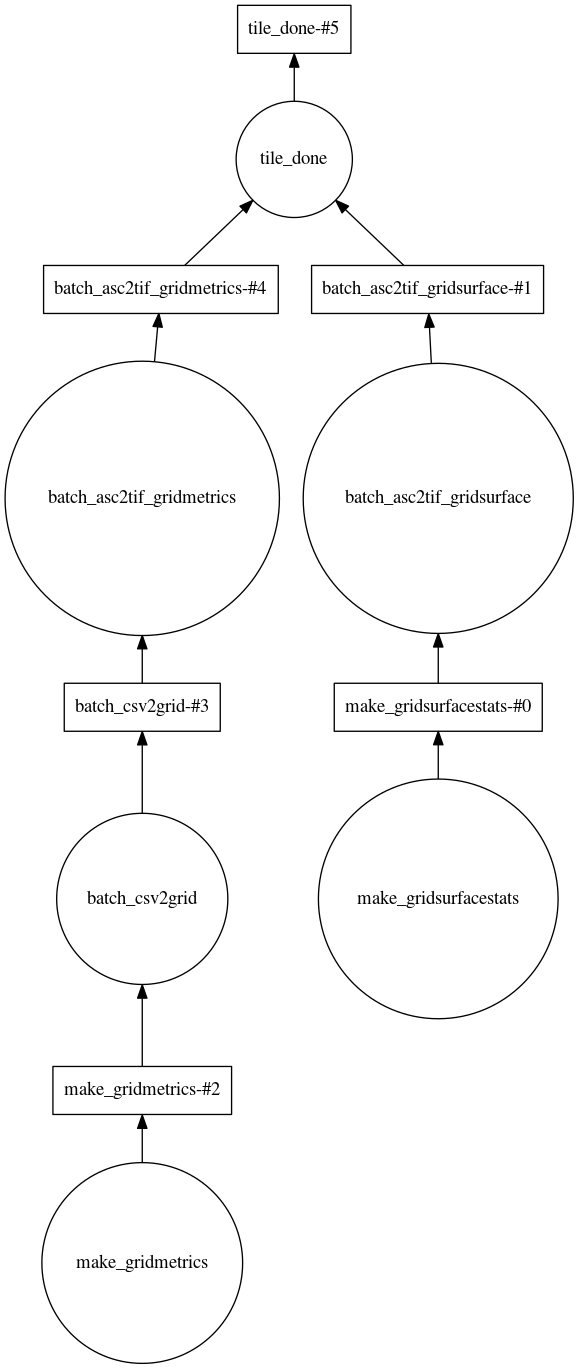

In [19]:
example_tile_graph = c.get(dsk, 'tile_done-{}'.format(tiles_to_process[0]))
example_tile_graph.visualize()

In [20]:
tiles_graph = c.get(dsk, 'tiles_done')

In [21]:
tiles_results = c.compute(tiles_graph) # this might take a while...

In [22]:
progress(tiles_results)

VBox()

In [23]:
# c.cancel(tiles_results)

In [24]:
# tiles_results.result()

In [35]:
failed = glob.glob(os.path.join(INTERIM, 'failed', '*.txt'))
finished = [os.path.basename(tile).split('.')[0] for tile in glob.glob(os.path.join(INTERIM, 'finished_gridmetrics', '*.txt'))]

summary = '''
Processing Summary
-------------------
{:>5,d} tiles in acquisition
{:>5,d} tiles previously finished in acquisition

{:>5,d} tiles being processed in this run
{:>5,d} tiles from this run finished

{:>5,d} tiles failed
'''.format(len(tile_ids), 
           len(finished_tiles),
           len(tiles_to_process), 
           len(finished) - (len(tile_ids) - len(tiles_to_process)), 
           len(failed))

total_percent_unfinished = int(70 * (1-len(finished)/len(tile_ids)))
total_percent_finished = int(70 * len(finished)/len(tile_ids))
total_percent_failed = int(70 * len(failed)/len(tile_ids))

this_run_unfinished = int(70 - 70*(len(finished) - (len(tile_ids) - len(tiles_to_process))) / len(tiles_to_process))
this_run_finished = int(70*(len(finished) - (len(tile_ids) - len(tiles_to_process))) / len(tiles_to_process))

print(summary)
print('|' + '=' * this_run_finished + 
      ' '* this_run_unfinished + 
      '!' * total_percent_failed + 
      '|  {:.1%} this run'.format(
          (len(finished) - (len(tile_ids) - len(tiles_to_process))) / len(tiles_to_process)))
print('|' + '=' * total_percent_finished + 
      ' ' * total_percent_unfinished + 
      '!' * total_percent_failed + 
      '|  {:.1%} total'.format(
          len(finished)/len(tile_ids)))


Processing Summary
-------------------
5,035 tiles in acquisition
    0 tiles previously finished in acquisition

5,035 tiles being processed in this run
5,035 tiles from this run finished

    0 tiles failed

|======================================================================|  100.0% this run
|======================================================================|  100.0% total


In [26]:
for filename in failed:
    with open(filename) as f:
        print([line for line in f.readlines() if line.rstrip() != ''])
    print('----------------------')

In [37]:
# c.close()
# cluster.close()